Murcko scaffoldとscaffold外の間の結合を求めたいという希望があったので関数を作成してみる。

In [1]:
from copy import deepcopy
import os
import random
import sys

from IPython.display import SVG

from rdkit import Chem
from rdkit import RDConfig
from rdkit import rdBase
from rdkit.Chem import rdDepictor, Draw, MurckoDecompose, PandasTools
from rdkit.Chem.Scaffolds.MurckoScaffold import GetScaffoldForMol
from rdkit.Chem.rdFMCS import FindMCS
from rdkit.Chem.Draw import rdMolDraw2D, IPythonConsole


%matplotlib inline

IPythonConsole.ipython_useSVG = True

print(sys.version_info)
print(f'RDKit version is {rdBase.rdkitVersion}')

sys.version_info(major=3, minor=6, micro=2, releaselevel='final', serial=0)
RDKit version is 2017.03.3


### 1. テストデータの用意

テストとしてRDKit内にあらかじめ用意されている200個の化合物を含むSDFを読み込み使用する。

In [2]:
sdf_file = os.path.join(RDConfig.RDDataDir, 'NCI/first_200.props.sdf')
sdf_file

'/opt/conda/share/RDKit/Data/NCI/first_200.props.sdf'

目視で確認するためにSMILESに基づいた化学構造とMurcko scaffoldsを含むデータフレームを作成してみる。

,SMILES,Molecule,Murcko_SMILES,Murcko_scaffold
0,CC1=CC(=O)C=CC1=O,,O=C1C=CC(=O)C=C1,
1,c1ccc2sc(SSc3nc4ccccc4s3)nc2c1,,c1ccc2sc(SSc3nc4ccccc4s3)nc2c1,
2,O=[N+]([O-])c1cc(Cl)c(O)c([N+](=O)[O-])c1,,c1ccccc1,
3,N=c1[nH]cc([N+](=O)[O-])s1,,N=c1[nH]ccs1,

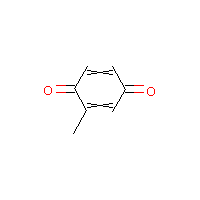
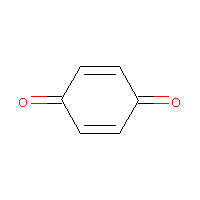
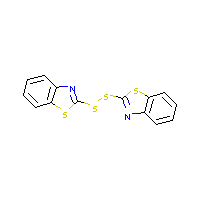
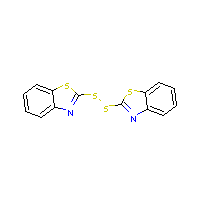
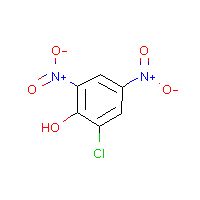
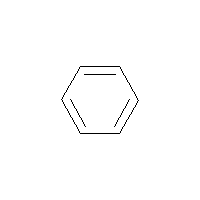
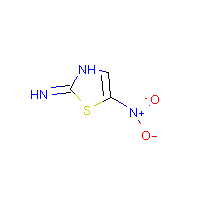
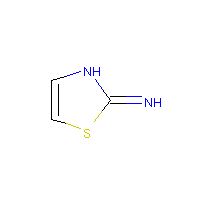

In [3]:
frame = PandasTools.LoadSDF(sdf_file, smilesName='SMILES', molColName='Molecule', includeFingerprints=False)
PandasTools.AddMurckoToFrame(frame, molCol='Molecule', MurckoCol='Murcko_SMILES')
PandasTools.AddMoleculeColumnToFrame(frame, 'Murcko_SMILES', 'Murcko_scaffold')
frame.loc[:3, ['SMILES', 'Molecule', 'Murcko_SMILES', 'Murcko_scaffold']]

### 2. Murcko_scaffoldの抽出

Murcko_scaffoldをMolオブジェクトとして取り出すには [GetScaffoldForMol関数](http://www.rdkit.org/Python_Docs/rdkit.Chem.Scaffolds.MurckoScaffold-module.html#GetScaffoldForMol) を用いる。  
例として上のデータフレームのID 3の化学構造に対して関数を適用してみる。

In [4]:
smiles = 'N=c1[nH]cc([N+](=O)[O-])s1'
mol = Chem.MolFromSmiles(smiles)
scaffold = GetScaffoldForMol(mol)

確認のため図にしてみる。

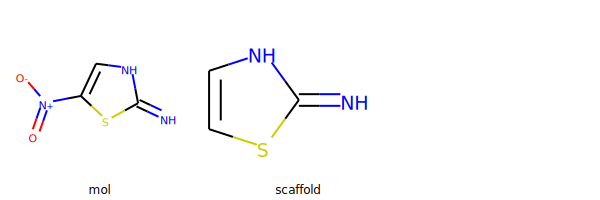

In [5]:
Draw.MolsToGridImage([mol, scaffold], legends=['mol', 'scaffold'])

データフレームで記述されている図と同様であり正常に機能しているようだ。

#### 2.1 scaffold原子のindex情報の抽出

得られたscaffoldの分子中の原子のindex情報を取り出すには `GetIdx` メソッドを用いる。

In [6]:
atoms = scaffold.GetAtoms()
for atom in atoms:
    print(atom.GetIdx(), atom.GetSymbol())

0 N
1 C
2 N
3 C
4 C
5 S


In [7]:
atoms = mol.GetAtoms()
for atom in atoms:
    print(atom.GetIdx(), atom.GetSymbol())

0 N
1 C
2 N
3 C
4 C
5 N
6 O
7 O
8 S


`GetSymbol` メソッドの結果も同時に出力することでmolとscaffoldでindexが対応していないことがわかる。  
どうやらscaffoldのmolオブジェクトは新規に作成されているようだ。対応してないとプログラムを作成する際にかなり厄介である。

そこで`GetScaffoldForMol`関数の[ソースコード](http://www.rdkit.org/Python_Docs/rdkit.Chem.Scaffolds.MurckoScaffold-pysrc.html#GetScaffoldForMol)を調べてみると、[Chem.MurckoDecompose](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdmolops-module.html#MurckoDecompose)関数を最初に実行しているようである。

In [8]:
test_scaffold = MurckoDecompose(mol)
atoms = test_scaffold.GetAtoms()
for atom in atoms:
    print(atom.GetIdx(), atom.GetSymbol())

0 N
1 C
2 N
3 C
4 C
5 S


この時点で既にIDの情報が更新されているようだ。[Chem.MurckoDecompose](http://www.rdkit.org/Python_Docs/rdkit.Chem.rdmolops-module.html#MurckoDecompose)関数のソースコードはC++らしくこれ以上詳しく調べるのはやめる。  
色々googlingしたところ[こちらのサイト](http://cheminformist.itmol.com/TEST/?p=571)のスクリプト例を真似るのがよさそうなので一度試してみる。

得られたscaffoldに対してmolオブジェクトの`GetSubstructMatch`メソッドを実行してマッチする原子のIDを取り出す。

In [9]:
scaffold_atom_indices = mol.GetSubstructMatch(scaffold)
scaffold_atom_indices

(0, 1, 2, 3, 4, 8)

In[7]と比較したところ正しく取り出せているのでこの手法でオリジナルの分子のindexを取り出すことにする。

### 3. scaffoldからscaffold外に伸びている結合の抽出

#### 3.1 試行実験

続けてscaffoldの各原子の結合を取り出す。以下では例としてindex0の原子について作業をすすめる。

In [10]:
atoms = mol.GetAtoms()
atom = atoms[0]

原子に結合する結合を取り出すには`GetBonds`メソッドを用いる。

In [11]:
bonds = atom.GetBonds()
bonds

(<rdkit.Chem.rdchem.Bond at 0x7fd8f2e28cb0>,)

得られた結合のもう一つの原子のindexは`GetOtherAtomIdx`メソッドを用いることで取り出せる。

In [12]:
bond = bonds[0]
bond.GetOtherAtomIdx(0)

1

この結合はindex0, 1の原子の間の結合だとわかる。そしてscaffold_atom_indicesにどちらも含まれているのでこの結合はscaffold内の結合である。

In [13]:
bond.GetOtherAtomIdx(0) in scaffold_atom_indices

True

#### 3.2 抽出をするスクリプトのまとめ

以上のことを踏まえると以下のようにコードを書くことでscaffoldからscaffold外に伸びている結合を取り出せる。

In [14]:
boundary_bonds = []
for atom_idx in scaffold_atom_indices:
    for bond in mol.GetAtomWithIdx(atom_idx).GetBonds():
        if bond.GetOtherAtomIdx(atom_idx) not in scaffold_atom_indices:
            boundary_bonds.append(bond)            

In [15]:
for bond in boundary_bonds:
    print(bond.GetIdx())

4


内包表記を使って書くと以下のようになる。

In [16]:
boundary_bonds = [bond for atom_idx in scaffold_atom_indices for bond in mol.GetAtomWithIdx(atom_idx).GetBonds()
                                                                                                if bond.GetOtherAtomIdx(atom_idx) not in scaffold_atom_indices]

In [17]:
for bond in boundary_bonds:
    print(bond.GetIdx())

4


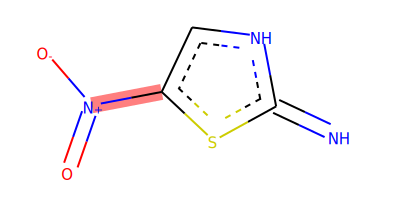

In [18]:
highlight=[4]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=highlight)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

正しくscaffoldからscaffold外に伸びている結合を取り出すことができた。

#### 3.3 抽出をするスクリプトの関数化

スクリプトが正常に動くことが確認できたので関数にする。  
Murcko scaffoldからscaffold外へ伸びる結合を取り出す関数`find_boundary_bonds`を作成する。  
柔軟性を考えてユーザがatom_indicesを設定できるよう(つまりMurcko scaffold以外でも良い)にし、  
何も設定しない時はMurcko scaffoldを関数内で求めるようにした。

In [19]:
def find_boundary_bonds(mol, scaffold_atom_indices=None):
    if not scaffold_atom_indices:
        scaffold = GetScaffoldForMol(mol)    
        scaffold_atom_indices = mol.GetSubstructMatch(scaffold)        
    return [bond for atom_idx in scaffold_atom_indices for bond in mol.GetAtomWithIdx(atom_idx).GetBonds()
                                                                                    if bond.GetOtherAtomIdx(atom_idx) not in scaffold_atom_indices]

In [20]:
boundary_bonds = find_boundary_bonds(mol)
for bond in boundary_bonds:
    print(bond.GetIdx())

4


In [21]:
boundary_bonds = find_boundary_bonds(mol, scaffold_atom_indices)
for bond in boundary_bonds:
    print(bond.GetIdx())

4


引数あるなしいずれでも正しく動いているようだ。

#### 4. 他の構造でのテスト

#### 4.1 サブセットの準備

いくつかの構造でも同様に正常に動作するか確認する。今回はランダムに取り出した10構造で試す。  
まずデータフレームの`reindex`メソッドを用いてランダムに並び替えることができるようだが再現性が担保できないので  
再現性が担保できる[random.sample](https://docs.python.jp/3/library/random.html#random.sample)関数でランダムなID番号を10個まず発生させる。

In [22]:
random.seed(1)

In [23]:
random_idxes = random.sample(range(0, frame.shape[0]), 10)
random_idxes

[34, 145, 195, 16, 65, 30, 126, 194, 115, 120]

このランダムなID番号でframeを絞り込む。

,SMILES,Molecule,Murcko_SMILES,Murcko_scaffold
34,O=[N+]([O-])c1cnc2cc(Cl)ccc2c1O,,c1ccc2ncccc2c1,
145,O=S(=O)(O)c1ccccc1,,c1ccccc1,
195,O=C(C=Cc1cccnc1)c1ccccc1,,O=C(C=Cc1cccnc1)c1ccccc1,
16,CCCCCCCCCCCCCCCc1cc(O)ccc1N,,c1ccccc1,
65,CC(=O)C(Cc1ccccc1)(c1ccccc1)c1ccccc1,,c1ccc(CC(c2ccccc2)c2ccccc2)cc1,
30,Cc1cc(C)c(N)c(C)c1,,c1ccccc1,
126,CC(=O)N1c2ccccc2Sc2ccc(C(=O)CCl)cc21,,c1ccc2c(c1)Nc1ccccc1S2,
194,CNCC(N)=O,,,
115,O=C(CCCC(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F)OCC(F)(F)C(F)(F)C(F)(F)C(F)F,,,
120,CCN1c2ccccc2Sc2ccccc21,,c1ccc2c(c1)Nc1ccccc1S2,

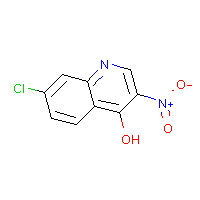
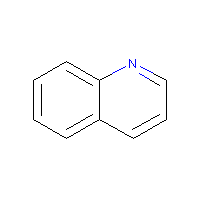
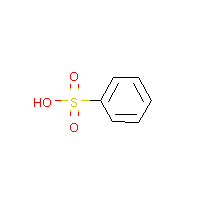
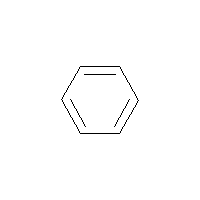
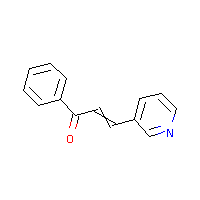
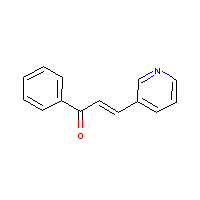
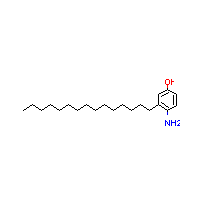
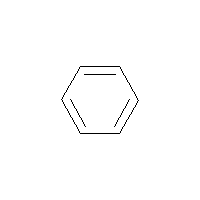
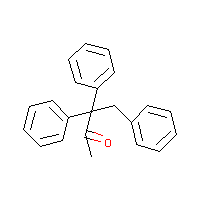
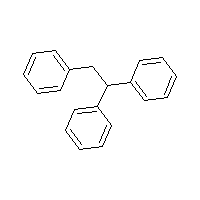
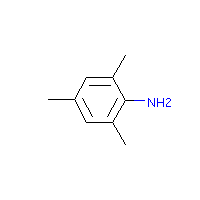
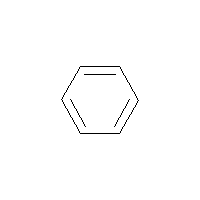
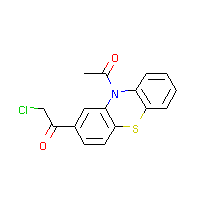
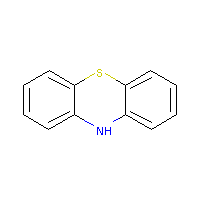
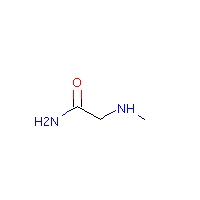
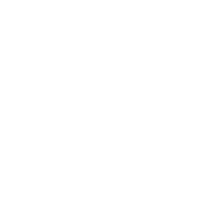
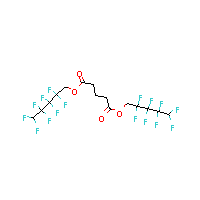
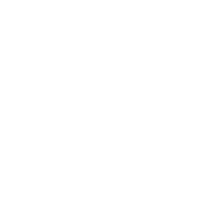
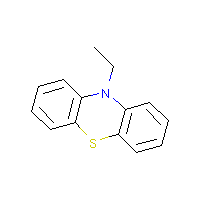
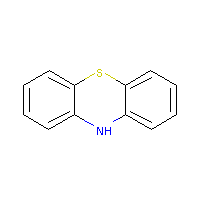

In [24]:
subset = frame.loc[random_idxes, ['SMILES', 'Molecule', 'Murcko_SMILES', 'Murcko_scaffold']]
subset

#### 4.2 テスト

##### 4.2.1 引数なし

この10個の化学構造に対して作成した関数を引数なしで実行してみる。

In [25]:
smiles_set = list(subset['SMILES'])
smiles_set

['O=[N+]([O-])c1cnc2cc(Cl)ccc2c1O',
 'O=S(=O)(O)c1ccccc1',
 'O=C(C=Cc1cccnc1)c1ccccc1',
 'CCCCCCCCCCCCCCCc1cc(O)ccc1N',
 'CC(=O)C(Cc1ccccc1)(c1ccccc1)c1ccccc1',
 'Cc1cc(C)c(N)c(C)c1',
 'CC(=O)N1c2ccccc2Sc2ccc(C(=O)CCl)cc21',
 'CNCC(N)=O',
 'O=C(CCCC(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F)OCC(F)(F)C(F)(F)C(F)(F)C(F)F',
 'CCN1c2ccccc2Sc2ccccc21']

In [26]:
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_set]

Jupyter上で図にする部分は関数にできないので冗長ではあるがほぼ同じスクリプトを書き続けてみる。

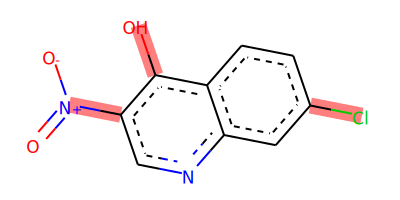

In [27]:
mol = mols[0]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

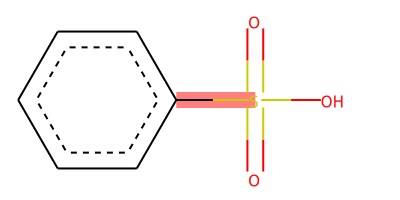

In [28]:
mol = mols[1]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

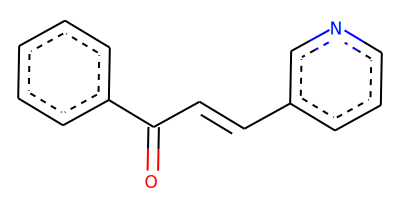

In [29]:
mol = mols[2]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

この化学構造はすべてがMurcko scaffoldなのでハイライトされてないのが正しい。

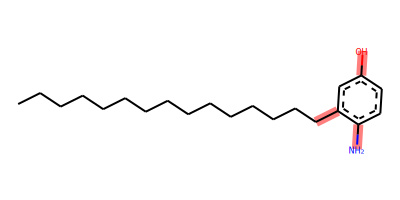

In [30]:
mol = mols[3]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

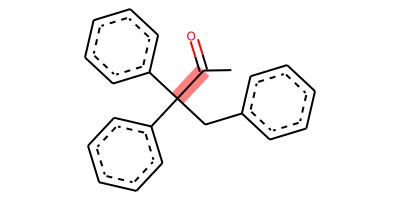

In [31]:
mol = mols[4]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

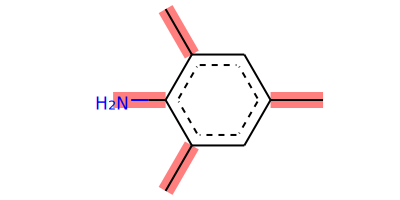

In [32]:
mol = mols[5]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

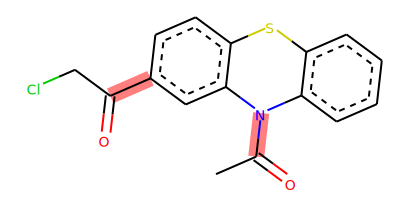

In [33]:
mol = mols[6]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

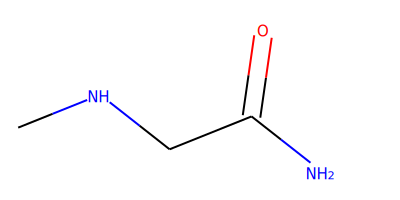

In [34]:
mol = mols[7]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

この化学構造はMurcko scaffoldsがないのでハイライトがないのは正しい。そもそもそのような場合はエラーや警告を出したほうが良い？

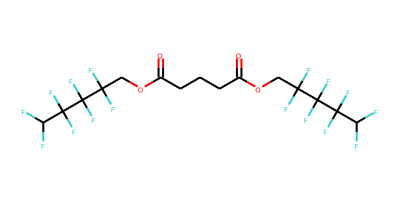

In [35]:
mol = mols[8]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

この化学構造もMurcko scaffoldsがないのでハイライトがないのは正しい。

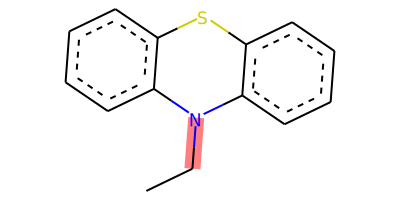

In [36]:
mol = mols[9]
bonds = find_boundary_bonds(mol)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

10個の化学構造すべてで正常に動作することを確認できた。

##### 4.2.1 引数あり

続けて関数を引数を与えて用いて正常に動作するか確認する。

In [37]:
amitriptyline = 'CN(C)CCC=C1c2ccccc2CCc3c1cccc3'
imipramine = 'CN(C)CCCN1c2ccccc2CCc3c1cccc3'
clomipramine = 'CN(C)CCCN1c2ccccc2CCc3c1cc(cc3)Cl'

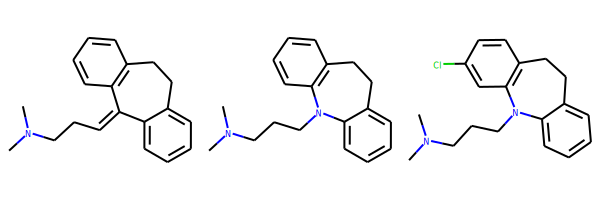

In [38]:
tca_smiles_set = [amitriptyline, imipramine, clomipramine]
tca_mols = [Chem.MolFromSmiles(smiles) for smiles in tca_smiles_set]
Draw.MolsToGridImage(tca_mols)

三環の部分をscaffoldと指定して関数を用いてみる。  
まず三環の部分の原子のインデックスを確認する。

In [39]:
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

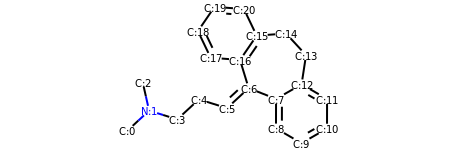

In [40]:
mol = deepcopy(tca_mols[0])
mol_with_atom_index(mol)

ここに図示するのは省略するが他の２個も確認したところ、すべてで三環の部分の原子のインデックスは6から20であった。

In [41]:
scaffold_atom_indices = list(range(6, 21))
scaffold_atom_indices

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

Jupyter上で図にする部分は関数にできないので冗長ではあるがほぼ同じスクリプトを書き続けてみる。

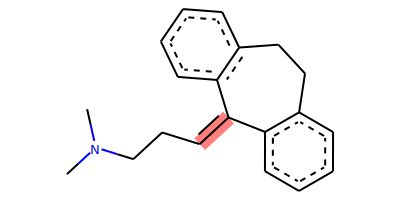

In [42]:
mol = tca_mols[0]
bonds = find_boundary_bonds(mol, scaffold_atom_indices)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

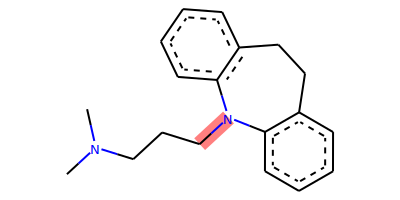

In [43]:
mol = tca_mols[1]
bonds = find_boundary_bonds(mol, scaffold_atom_indices)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

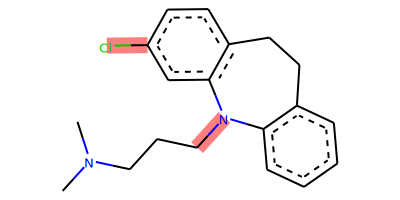

In [44]:
mol = tca_mols[2]
bonds = find_boundary_bonds(mol, scaffold_atom_indices)
bond_idxes = [bond.GetIdx() for bond in bonds]

rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(400,200)
drawer.DrawMolecule(mol, highlightAtoms=[], highlightBonds=bond_idxes)
drawer.FinishDrawing()
svg = drawer.GetDrawingText().replace('svg:','')
SVG(svg)

3個の化学構造ですべて正常に動作することが確認できた。

以上の検証によりfind_boundary_bonds関数を正しく作成することができたといえる。  
今後研究などに用いていきたい。